In [1]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th
import os

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Read all files

In [2]:
#1_trial is a name of a folder containing the cali files, you may create a folder with a different name and replace the folder name here
tk = th.Thicket.from_caliperreader(glob("Cali_Files/*.cali"))

(2/2) Creating Thicket: 100%|██████████| 7/7 [00:00<00:00, 31.97it/s]


In [3]:
print(tk.tree(metric_column="Avg time/rank"))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

0.320 main
├─ 0.003 MPI_Barrier
├─ 0.000 MPI_Comm_dup
├─ 0.000 MPI_Finalize
├─ 0.000 MPI_Finalized
├─ 0.000 MPI_Init
├─ 0.000 MPI_Initialized
├─ 0.000 comm
│  └─ 0.000 comm_small
│     └─ 0.000 MPI_Gather
├─ 0.023 comp
│  └─ 0.023 comp_large
│     └─ 0.000 comm
│        └─ 0.000 comm_large
│           ├─ 0.000 MPI_Recv
│           └─ 0.000 MPI_Send
├─ 0.000 correctness_check
└─ 0.001 data_init_runtime

Legend (Metric: Avg time/rank Min: 0.00 Max: 0.32 indices: {'profile': 1178313418})
█ 0.29 - 0.32
█ 0.22 - 0.29
█ 0.16 - 0.22
█ 0.10 - 0.16
█ 0.03 - 0.10
█ 0.00 - 0.03

name User code    ◀  Only in left graph    ▶  Only in right graph



In [4]:
tk.metadata_column_to_perfdata("num_procs")
tk.metadata_column_to_perfdata("input_size")
tk.metadata_column_to_perfdata("input_type")

tk.dataframe = tk.dataframe.reset_index().set_index(["node", "num_procs", "input_size", "input_type"]).sort_index()

tk.dataframe.head()

profile  \
node                                 num_procs input_size input_type               
{'name': 'main', 'type': 'function'} 2         65536      Random      1178313418   
                                                          Sorted      3896636460   
                                     4         65536      Random      4204206069   
                                                          Sorted      1897425985   
                                     8         65536      Random      2780904018   

                                                                      nid  \
node                                 num_procs input_size input_type        
{'name': 'main', 'type': 'function'} 2         65536      Random      1.0   
                                                          Sorted      1.0   
                                     4         65536      Random      1.0   
                                                          Sorted      1.0   
                                     8         65536      Random      1.0   

                                                                       spot.channel  \
node                                 num_procs input_size input_type                  
{'name': 'main', 'type': 'function'} 2         65536      Random      regionprofile   
                                                          Sorted      regionprofile   
                                     4         65536      Random      regionprofile   
                                                          Sorted      regionprofile   
                                     8         65536      Random      regionprofile   

                                                                      Min time/rank  \
node                                 num_procs input_size input_type                  
{'name': 'main', 'type': 'function'} 2         65536      Random           0.320116   
                                                          Sorted           0.320151   
                                     4         65536      Random           0.350163   
                                                          Sorted           0.368553   
                                     8         65536      Random           0.498519   

                                                                      Max time/rank  \
node                                 num_procs input_size input_type                  
{'name': 'main', 'type': 'function'} 2         65536      Random           0.320119   
                                                          Sorted           0.321042   
                                     4         65536      Random           0.354554   
                                                          Sorted           0.368579   
                                     8         65536      Random           0.499415   

                                                                      Avg time/rank  \
node                                 num_procs input_size input_type                  
{'name': 'main', 'type': 'function'} 2         65536      Random           0.320118   
                                                          Sorted           0.320596   
                                     4         65536      Random           0.351628   
                                                          Sorted           0.368568   
                                     8         65536      Random           0.499177   

                                                                      Total time  \
node                                 num_procs input_size input_type               
{'name': 'main', 'type': 'function'} 2         65536      Random        0.640236   
                                                          Sorted        0.641192   
                                     4         65536      Random        1.406513   
                                                          Sorted        1.474273   


In [5]:
# Define common variables
num_procs = [2, 4, 8, 16, 32, 64]
input_size = [2**16, 2**18, 2**20, 2**22, 2**24, 2**26, 2**28]
input_types = ["Random", "Sorted", "ReverseSorted", "Perturbed"]

Group Performance data by `matrix_size` in the Thicket metadata table.

**For comp_large, comm, main: Strong scaling plots for each input_size with lines for input_type (7 plots - 4 lines each)**

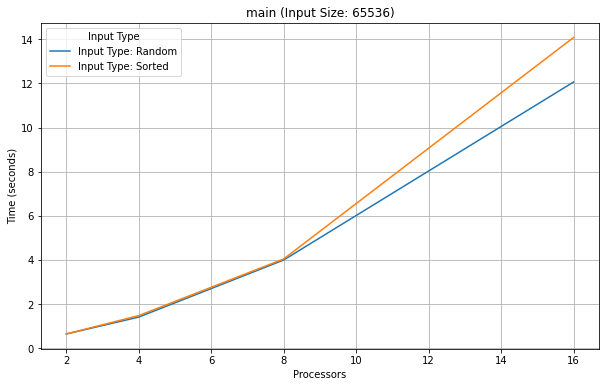

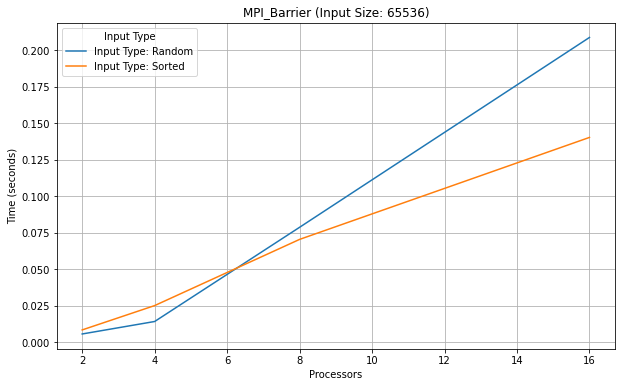

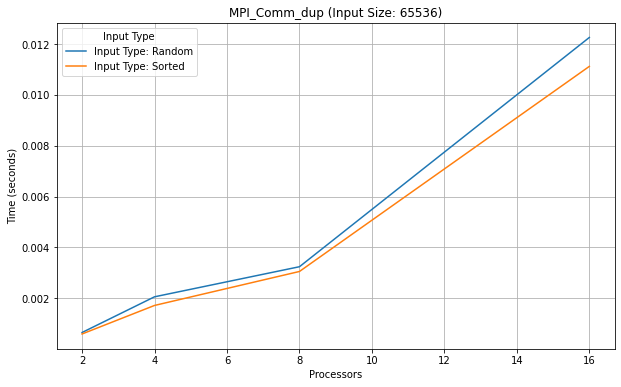

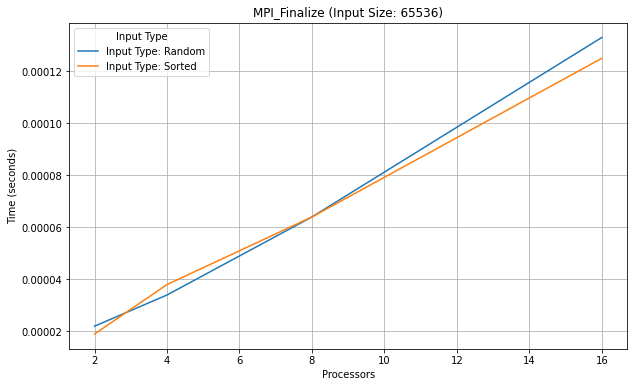

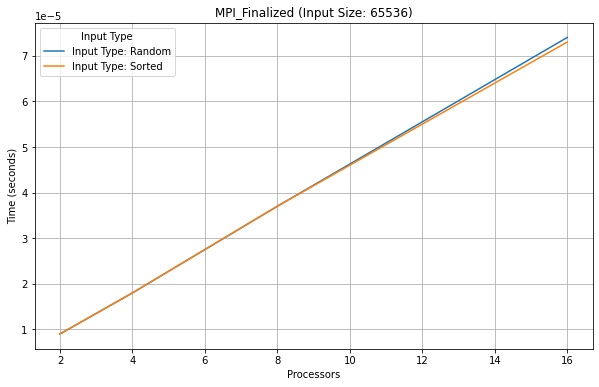

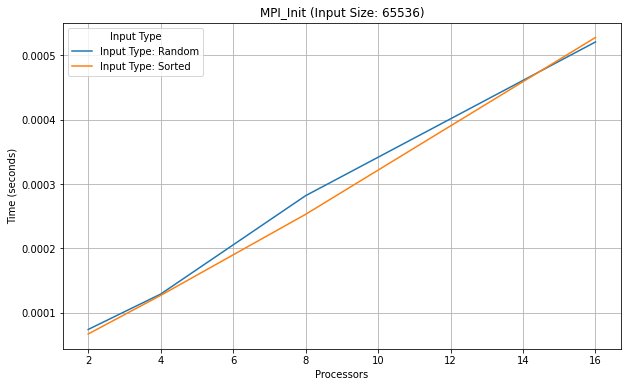

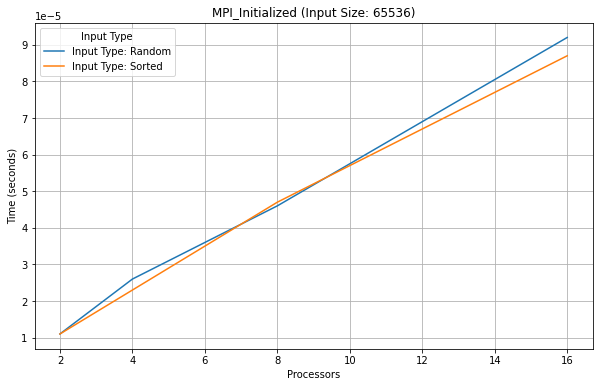

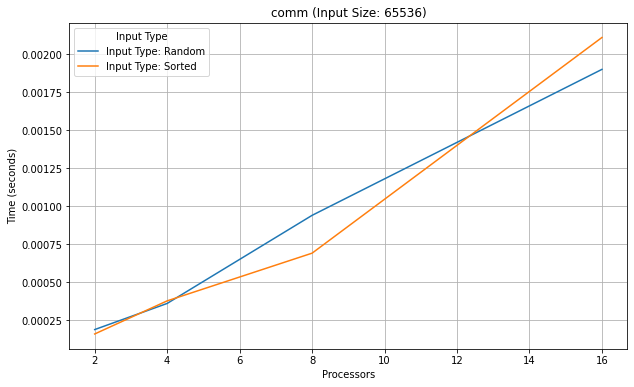

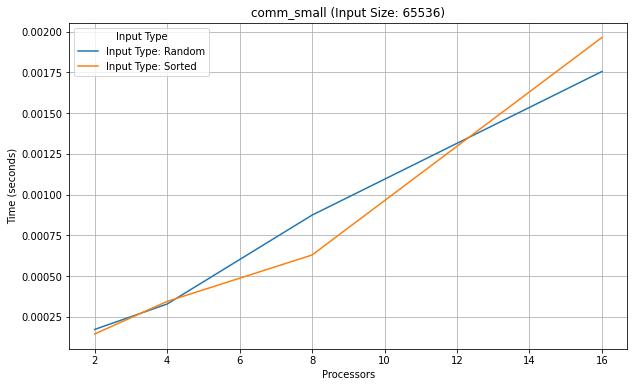

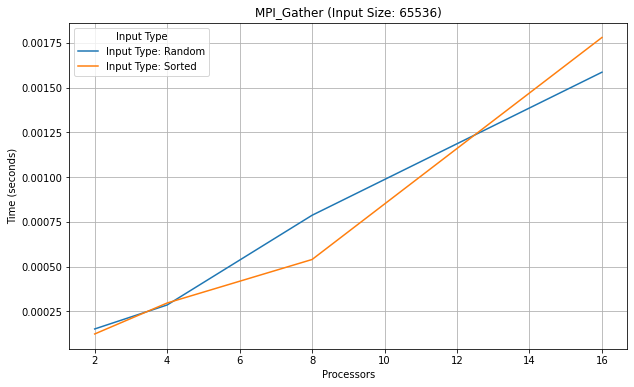

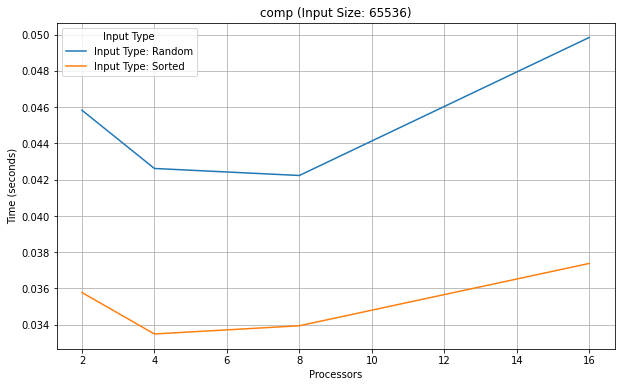

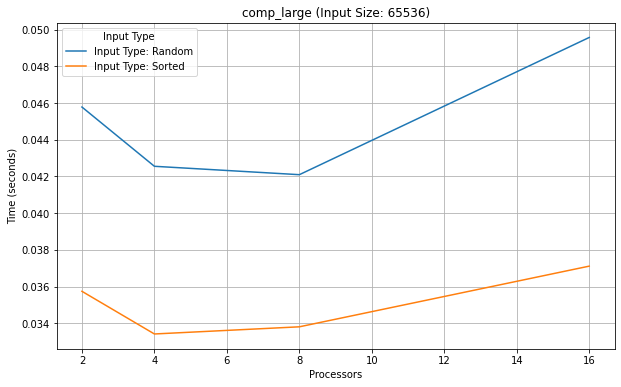

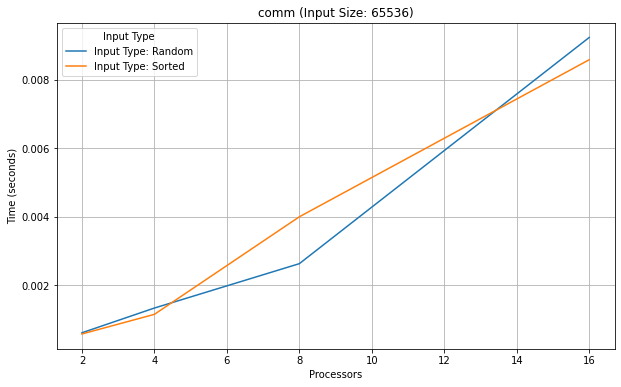

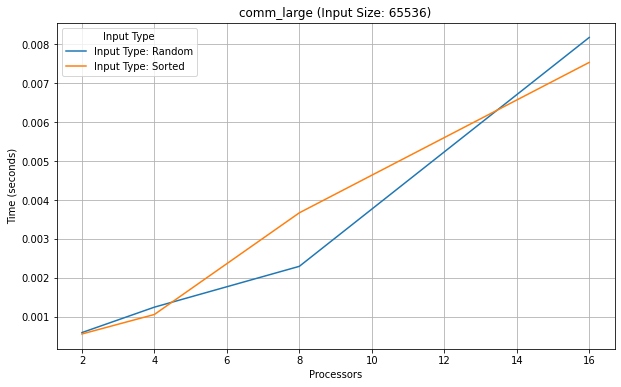

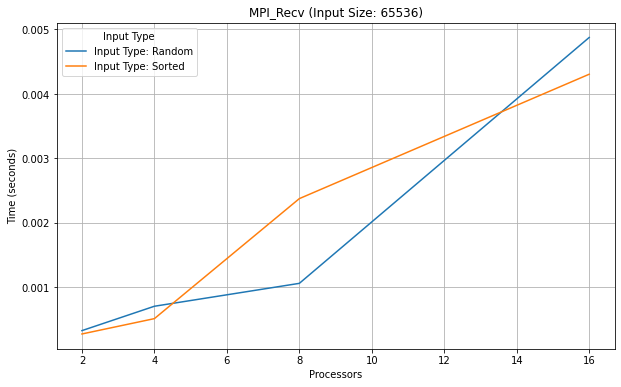

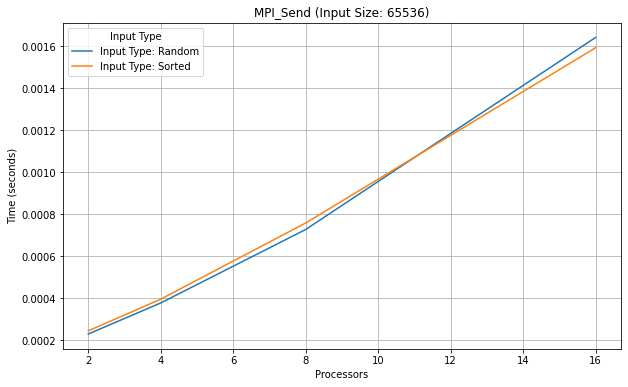

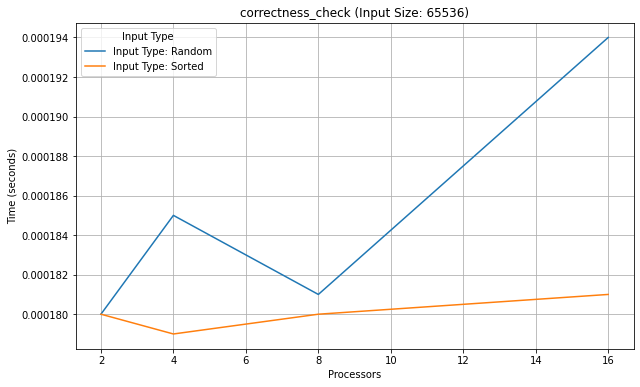

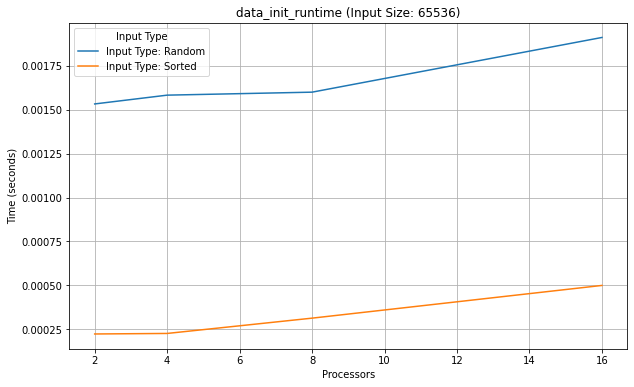

In [6]:
# Group by num_procs, input_size, and input_type, then aggregate for total, mean, min, max times
for node in tk.graph.traverse():
    # Unstack by input_type for the given node
    node_df = tk.dataframe.loc[node, "Total time"].unstack(level="input_type")
    
    # Get the unique input_sizes from the index
    input_sizes = node_df.index.get_level_values("input_size").unique()

    # Iterate over each unique input_size
    for input_size in input_sizes:
        # Filter the dataframe for the current input_size
        input_size_df = node_df.xs(input_size, level="input_size")
        
        # Create the plot
        plt.figure(figsize=(10, 6))
        
        # Plot each line for different input_types
        for input_type in input_size_df.columns:
            plt.plot(
                input_size_df.index.get_level_values("num_procs"),
                input_size_df[input_type],
                label=f"Input Type: {input_type}"
            )
        
        # Adding labels and title
        plt.xlabel("Processors")
        plt.ylabel("Time (seconds)")
        plt.title(f"{node.frame['name']} (Input Size: {input_size})")
        
        # Add legend and grid
        plt.legend(title="Input Type")
        plt.grid(True)
        
        # Show the plot
        plt.show()
